# Interactive Analysis
One need for bioimage analysts is to interactively perform analysis on images. This interaction could be manual parameter tuning, such as adjusting thresholds, or performing human-in-the-loop analysis through clicking on specific regions of an image.

**[napari](https://napari.org/)** makes such interactive analyses easy because of it's easy coupling with Python and Scientific Python ecosystem, including tools like **[numpy](https://numpy.org/)** and **[scikit-image](https://scikit-image.org/)**.

## Setup

In [1]:
# This cell is required to run these notebooks on Binder.
# If running on Binder, remember to **WAIT 5 SECONDS** after
# running the '%gui qt' cell below. If you get an error,
# click on "Kernel -> Restart" and try again. Make sure also
# that you have a desktop tab open.
import os
if 'BINDER_SERVICE_HOST' in os.environ:
    os.environ['DISPLAY'] = ':1.0'

We can then import `napari`, our `nbscreenshot` utility and instantiate an empty viewer.

In [1]:
import napari
from napari.utils import nbscreenshot

# Create an empty viewer
viewer = napari.Viewer()

Let's read the original image from previous lessons, take a maximum projection, and view it in napari:

In [2]:
from tifffile import imread

# Load the image data and inspect its shape
nuclei_mip = imread('data/nuclei.tif').max(axis=0)
print(nuclei_mip.shape)

(256, 256)


In [3]:
viewer.add_image(nuclei_mip);

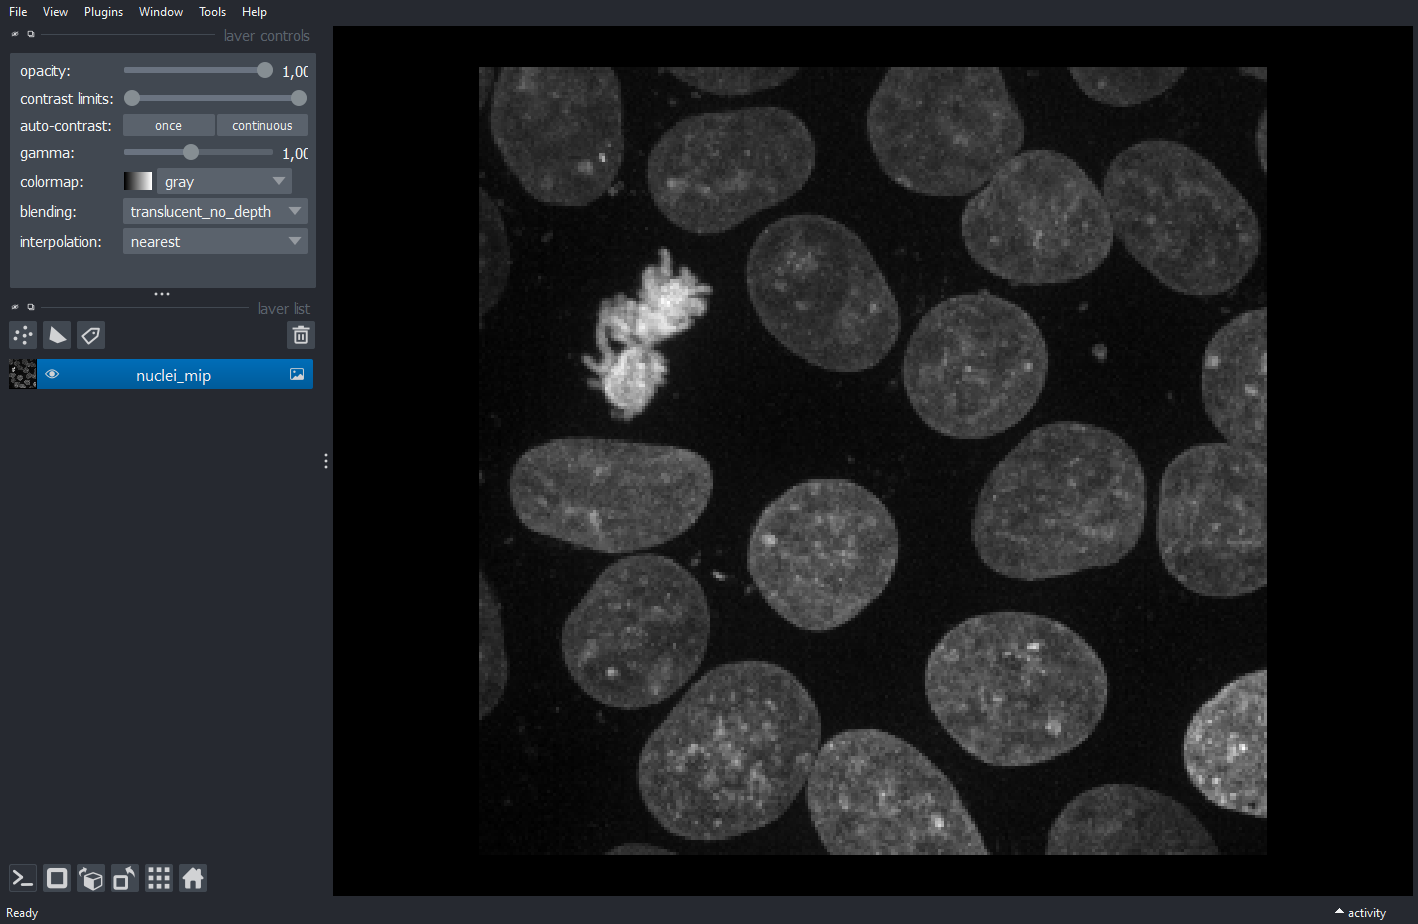

In [4]:
nbscreenshot(viewer)

## Visualizing image filtering results

One common task in image processing is **image filtering**, which can be used to denoise an image or detect edges or other features.

We can use **napari** to visualize the results of some of the image filters that come with the **scikit-image** library.

In [5]:
# Import scikit-image's filtering module
from skimage import filters

In [6]:
viewer.add_image(filters.sobel_h(nuclei_mip), name='Horizontal Sobel');
viewer.add_image(filters.sobel_v(nuclei_mip), name='Vertical Sobel');
viewer.add_image(filters.roberts(nuclei_mip), name='Roberts');
viewer.add_image(filters.prewitt(nuclei_mip), name='Prewitt');
viewer.add_image(filters.scharr(nuclei_mip), name='Scharr');

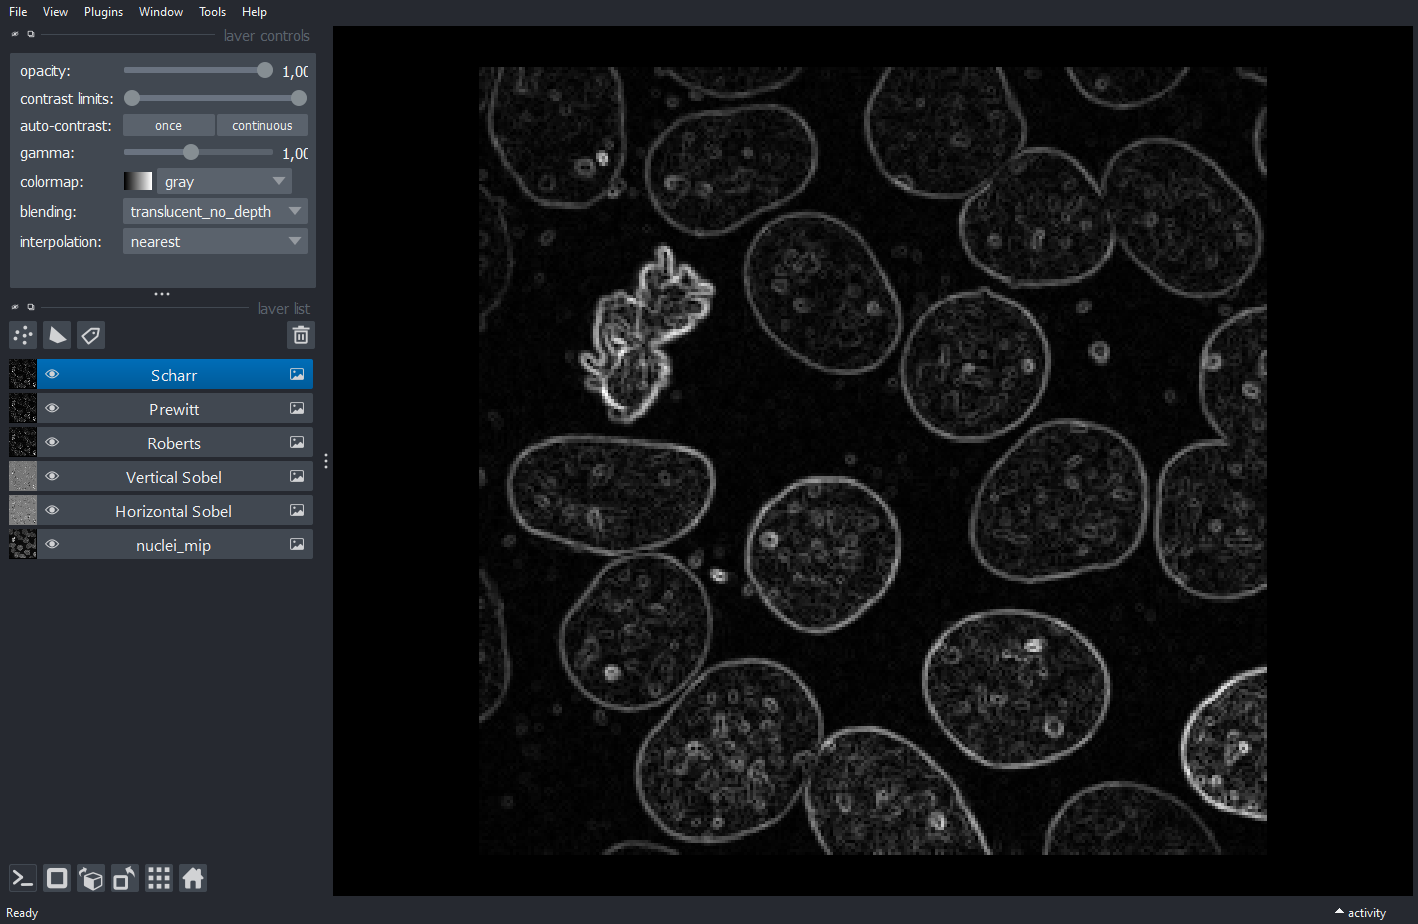

In [7]:
nbscreenshot(viewer)

In [8]:
# Remember all our layers are contained in a napari layerlist object
viewer.layers

[<Image layer 'nuclei_mip' at 0x25a6dc76370>, <Image layer 'Horizontal Sobel' at 0x25a70906a30>, <Image layer 'Vertical Sobel' at 0x25a721badc0>, <Image layer 'Roberts' at 0x25a7224c850>, <Image layer 'Prewitt' at 0x25a722f5dc0>, <Image layer 'Scharr' at 0x25a723829a0>]

In [9]:
# Remove all filter layers (except Image layer at index 0)
for l in viewer.layers[1:]:
    viewer.layers.remove(l)

## Interactive segmentation

Let's now perform an interactive segmentation of the nuclei using processing utilities from scikit-image.

In [10]:
from skimage import morphology
from skimage import feature
from skimage import measure
from skimage import segmentation
from scipy import ndimage
import numpy as np

First let's try and separate background from foreground using a threshold. Here we'll use an automatically calculated threshold.

In [11]:
# The result of this >= operation is a boolean array, hence it is 
# displayed in Napari as a Labels layer
foreground = nuclei_mip >= filters.threshold_li(nuclei_mip)
viewer.add_labels(foreground);

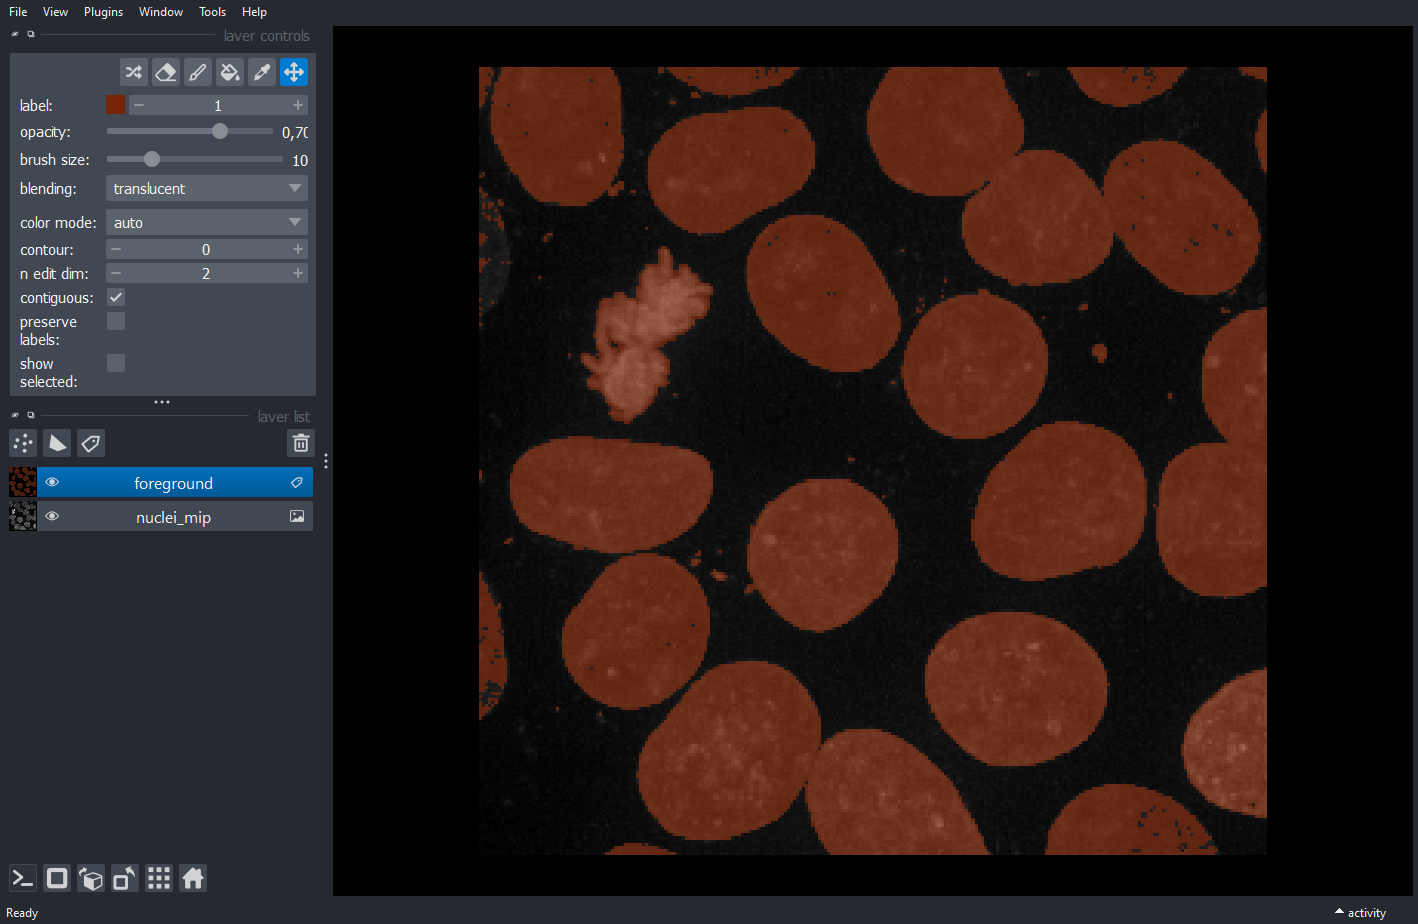

In [12]:
nbscreenshot(viewer)

Notice the debris located outside the nuclei and some of the holes located inside the nuclei. We will remove the debris by filtering out small objects, and fill the holes using a hole filling algorithm. We can update the data in the viewer in place.

In [13]:
foreground_processed = morphology.remove_small_holes(foreground, 60)
foreground_processed = morphology.remove_small_objects(foreground_processed, min_size=50)

viewer.layers['foreground'].data = foreground_processed

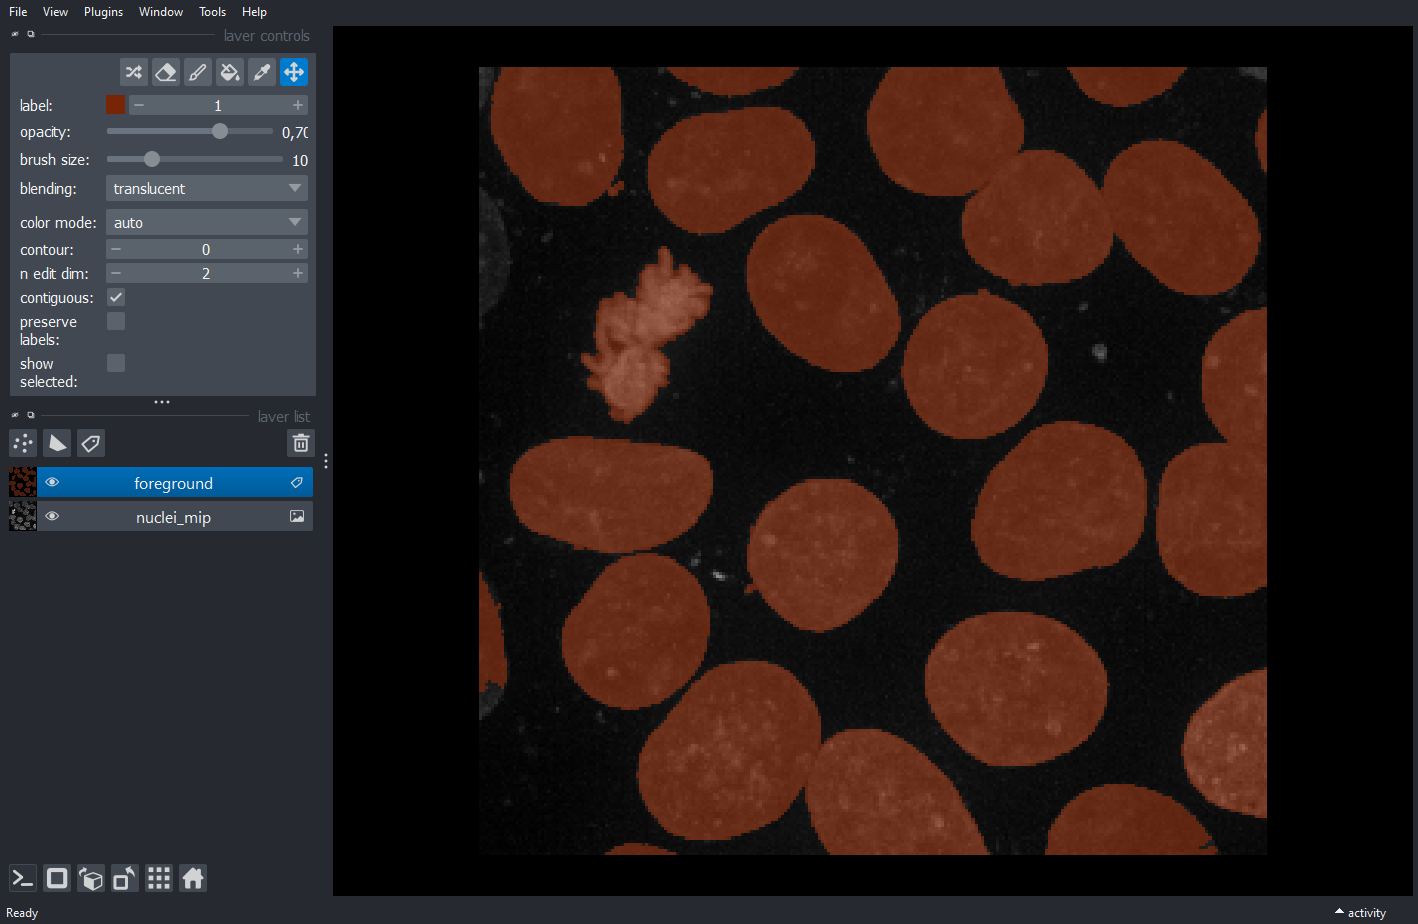

In [14]:
nbscreenshot(viewer)

We will now convert this binary mask into an **instance segmentation** where each nuclei is assigned a unique label.

We will do this using a **marker controlled watershed** approach. The first step in this procedure is to calculate a distance transform on the binary mask as follows.

In [15]:
distance = ndimage.distance_transform_edt(foreground_processed)
viewer.add_image(distance);

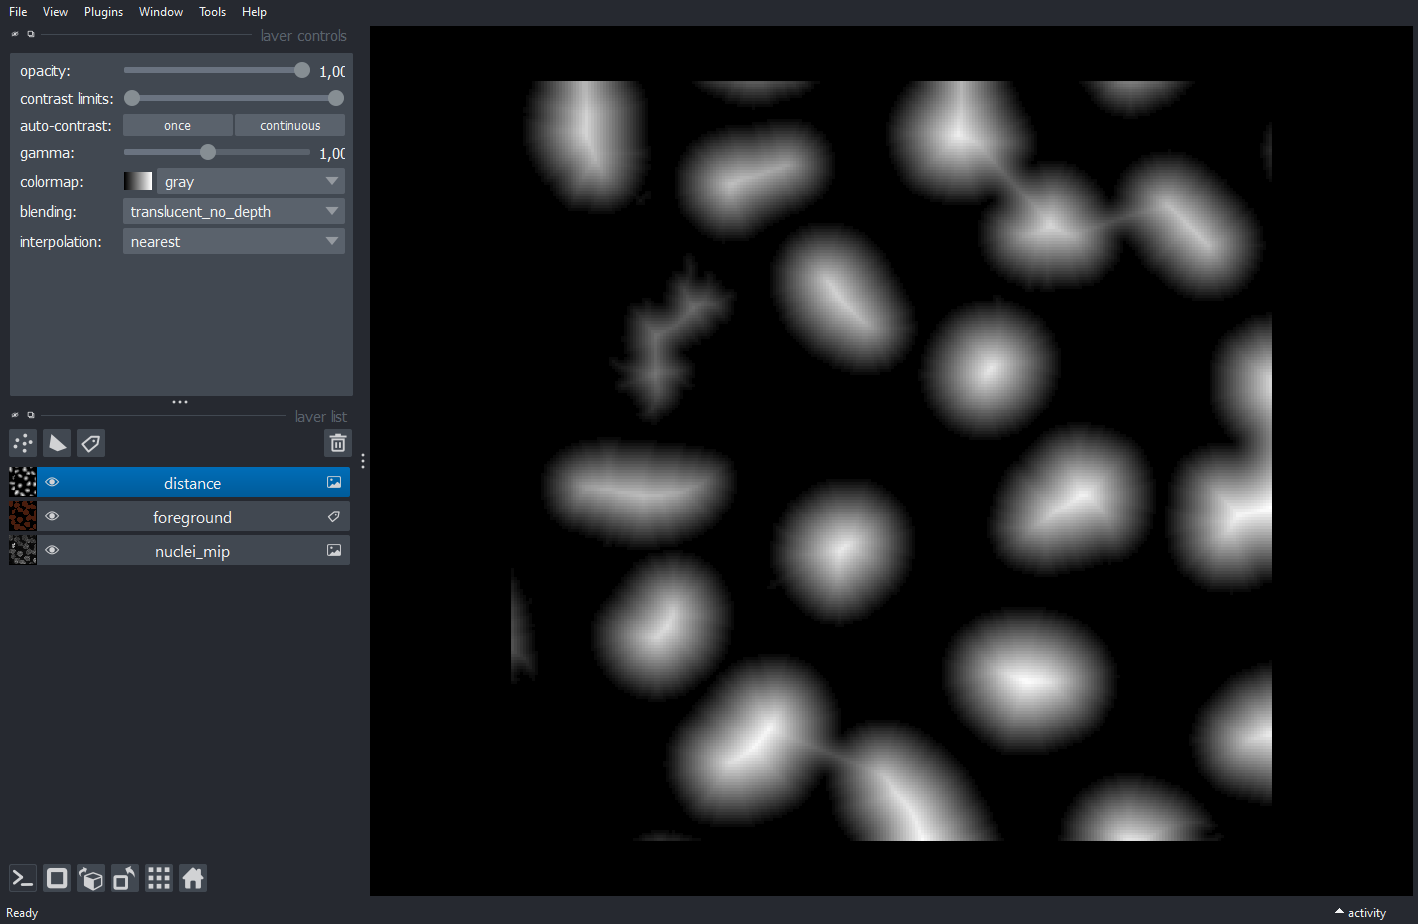

In [16]:
nbscreenshot(viewer)

We'll actually want to smooth the distance transform to avoid over segmentation artifacts. We can do this on the data in the viewer in place.

In [17]:
smoothed_distance = filters.gaussian(distance, 10)
viewer.layers['distance'].data = smoothed_distance

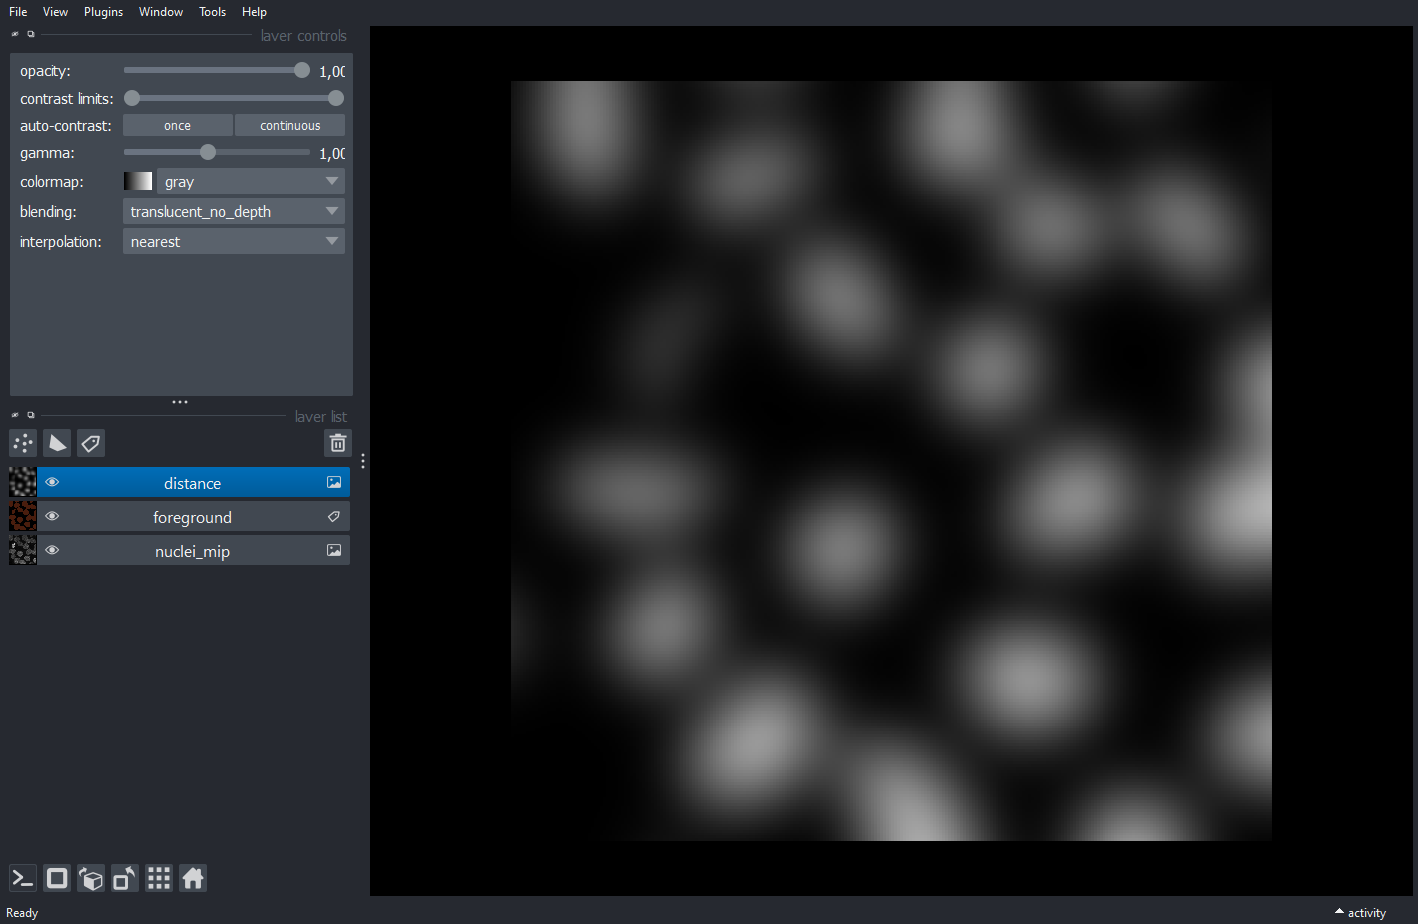

In [18]:
nbscreenshot(viewer)

Now we can try and identify the centers of each of the nuclei by finding peaks of the distance transform 

In [19]:
peaks = feature.peak_local_max(
    smoothed_distance,
    footprint=np.ones((7, 7), dtype=bool),
    labels=measure.label(foreground_processed)
)

In [20]:
viewer.add_points(peaks, name='peaks', size=5, face_color='red');

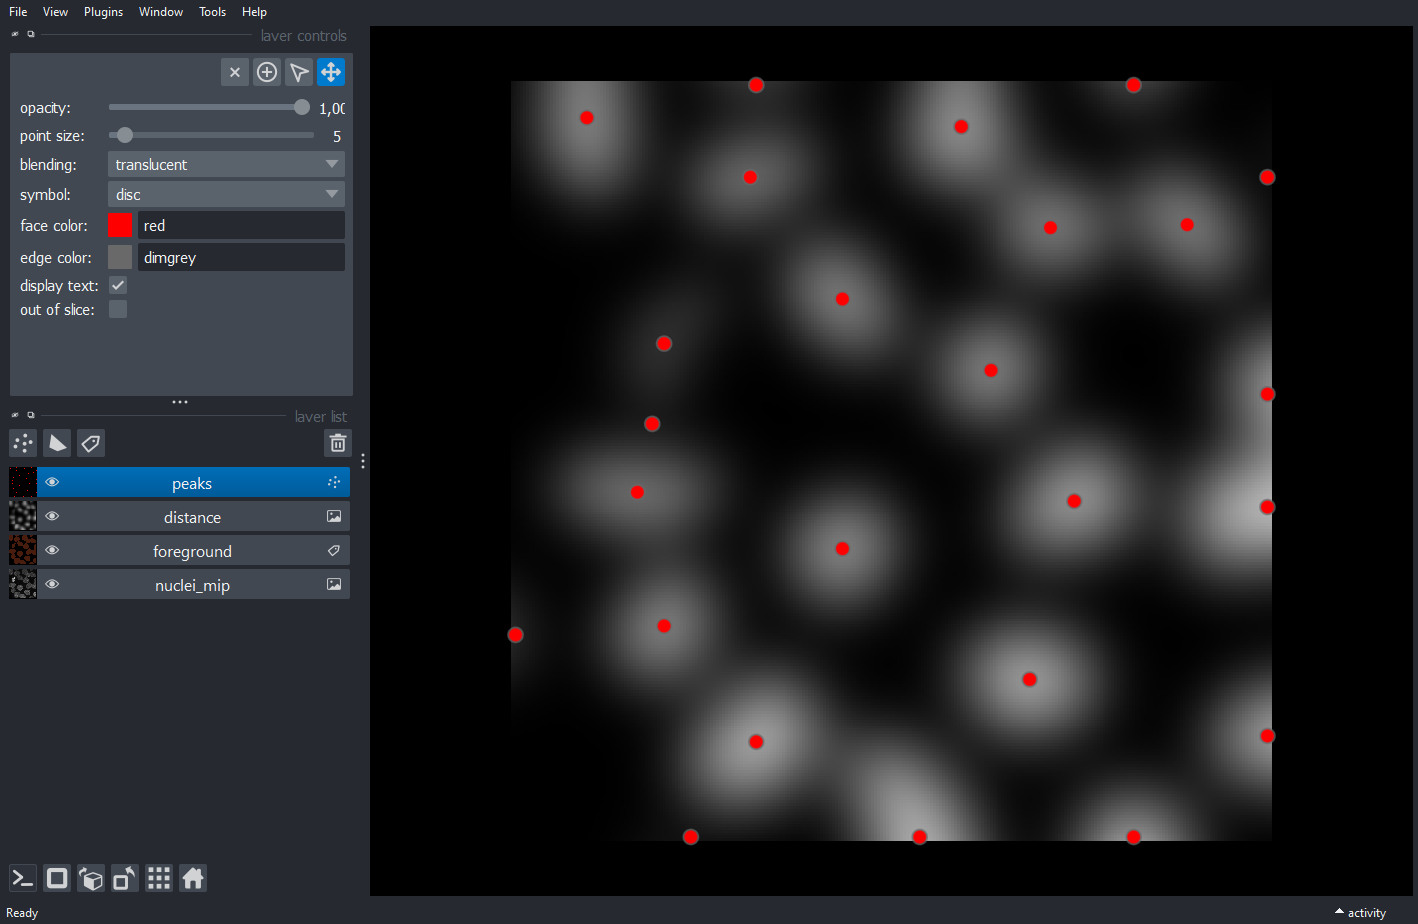

In [21]:
nbscreenshot(viewer)

We can now remove any of the points that don't correspond to nuclei centers or add any new ones using the GUI.

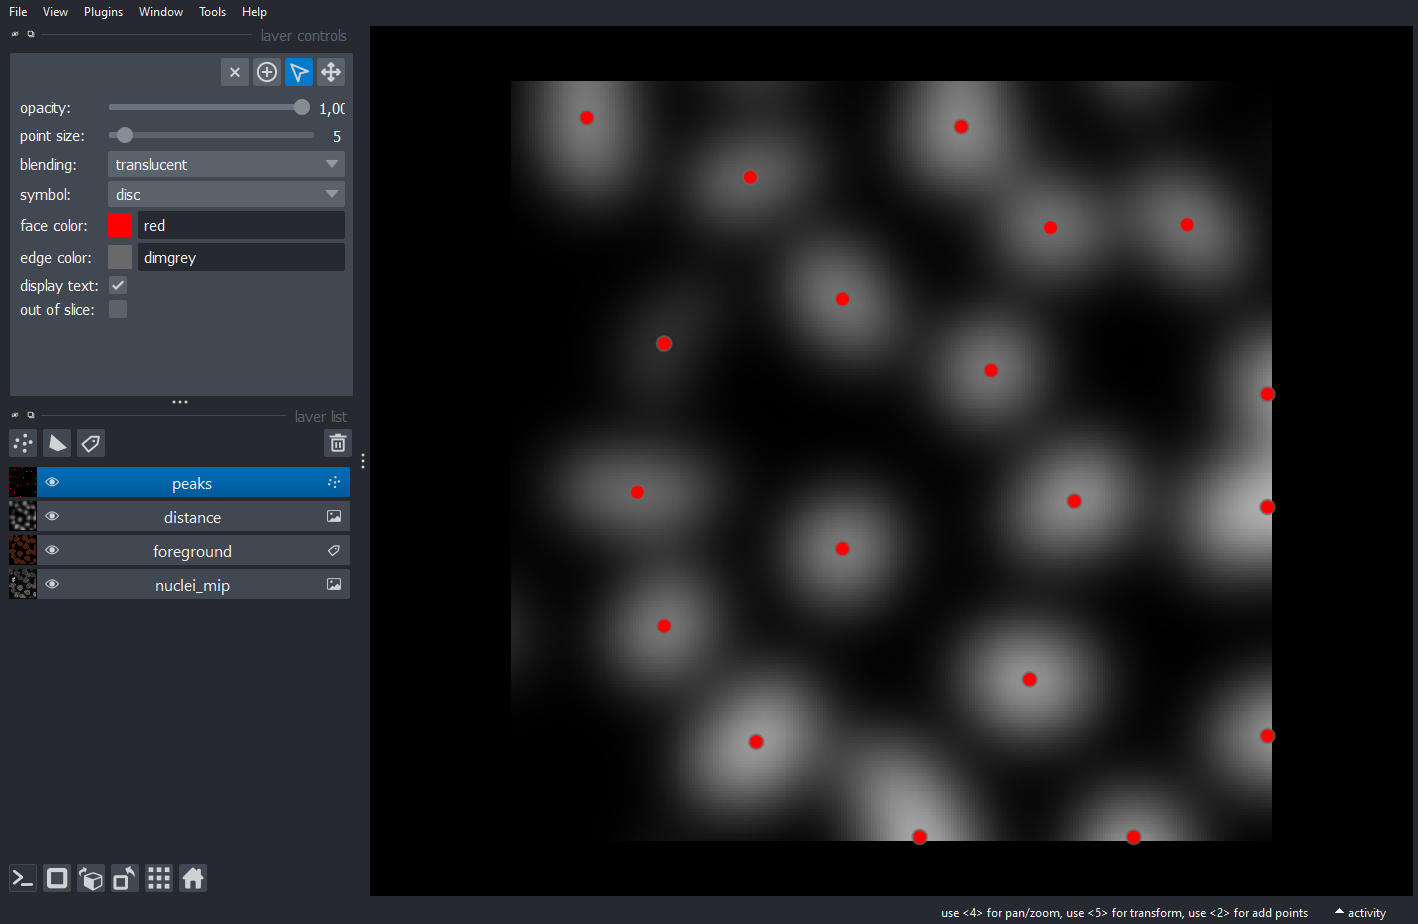

In [22]:
nbscreenshot(viewer)

Based on those peaks we can now seed the watershed algorithm which will find the nuclei boundaries. Manually adjust this in Napari by clicking on each point with the selection tool and deleting (either bin icon or hit del/supr on your keyboard)

In [23]:
new_peaks = np.round(viewer.layers['peaks'].data).astype(int).T
seeds = np.zeros(nuclei_mip.shape, dtype=bool)
seeds[(new_peaks[0], new_peaks[1])] = 1

markers = measure.label(seeds)
nuclei_segmentation = segmentation.watershed(
    -smoothed_distance, 
    markers, 
    mask=foreground_processed
)

viewer.add_labels(nuclei_segmentation);

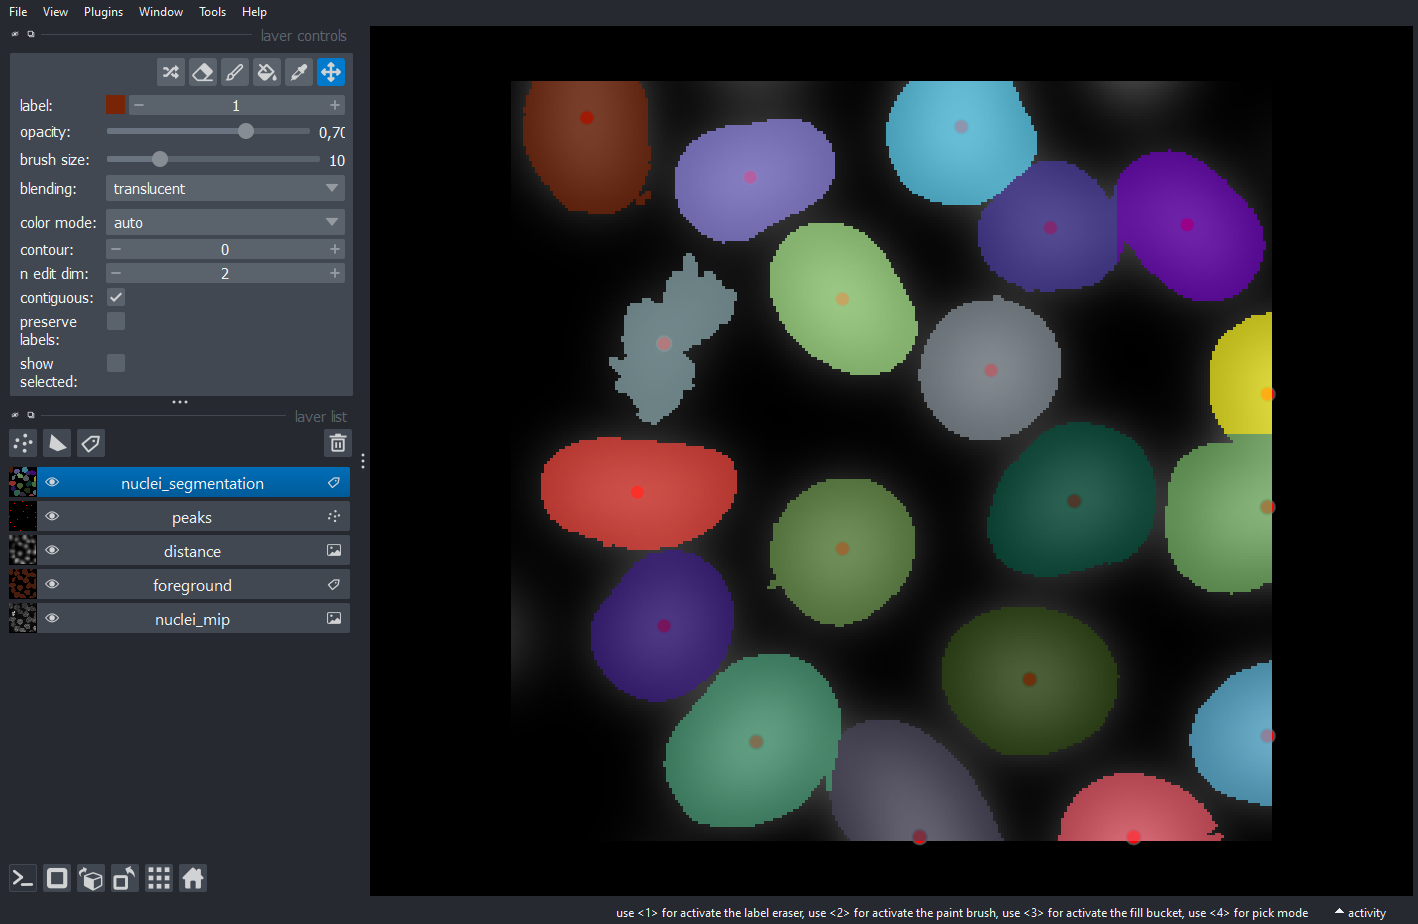

In [24]:
nbscreenshot(viewer)

We can now save our segmentation using our save method.

In [26]:
viewer.layers['nuclei_segmentation'].save('nuclei-automated-segmentation.tif');

## Interactive thresholding with a custom GUI element

Interactivity can be greatly enhanced by custom GUI elements like sliders and push buttons, custom mouse functions, or custom keybindings. **[napari](https://napari.org/)** can easily be extended with these features, and a companion library **[magicgui](https://napari.org/stable/guides/magicgui.html)** maintained by the napari team allows users to make extensions to the GUI without having to write any GUI code.

We'll now explore adding such interactivity to **napari**.

In [25]:
# Remove all processed layers
for l in viewer.layers[1:]:
    viewer.layers.remove(l)

In [26]:
# Import magicgui
from magicgui import magicgui
from napari.types import ImageData, LabelsData

@magicgui(auto_call=True,
          percentile={'widget_type': 'FloatSlider', 'min': 0, 'max': 100},
          layout='horizontal')
def threshold(layer: ImageData, percentile: int = 50) -> LabelsData:
    data_min = layer.min()
    data_max = layer.max()
    return layer.data > data_min + percentile / 100 * (data_max - data_min)

In [27]:
viewer.window.add_dock_widget(threshold, area='bottom');

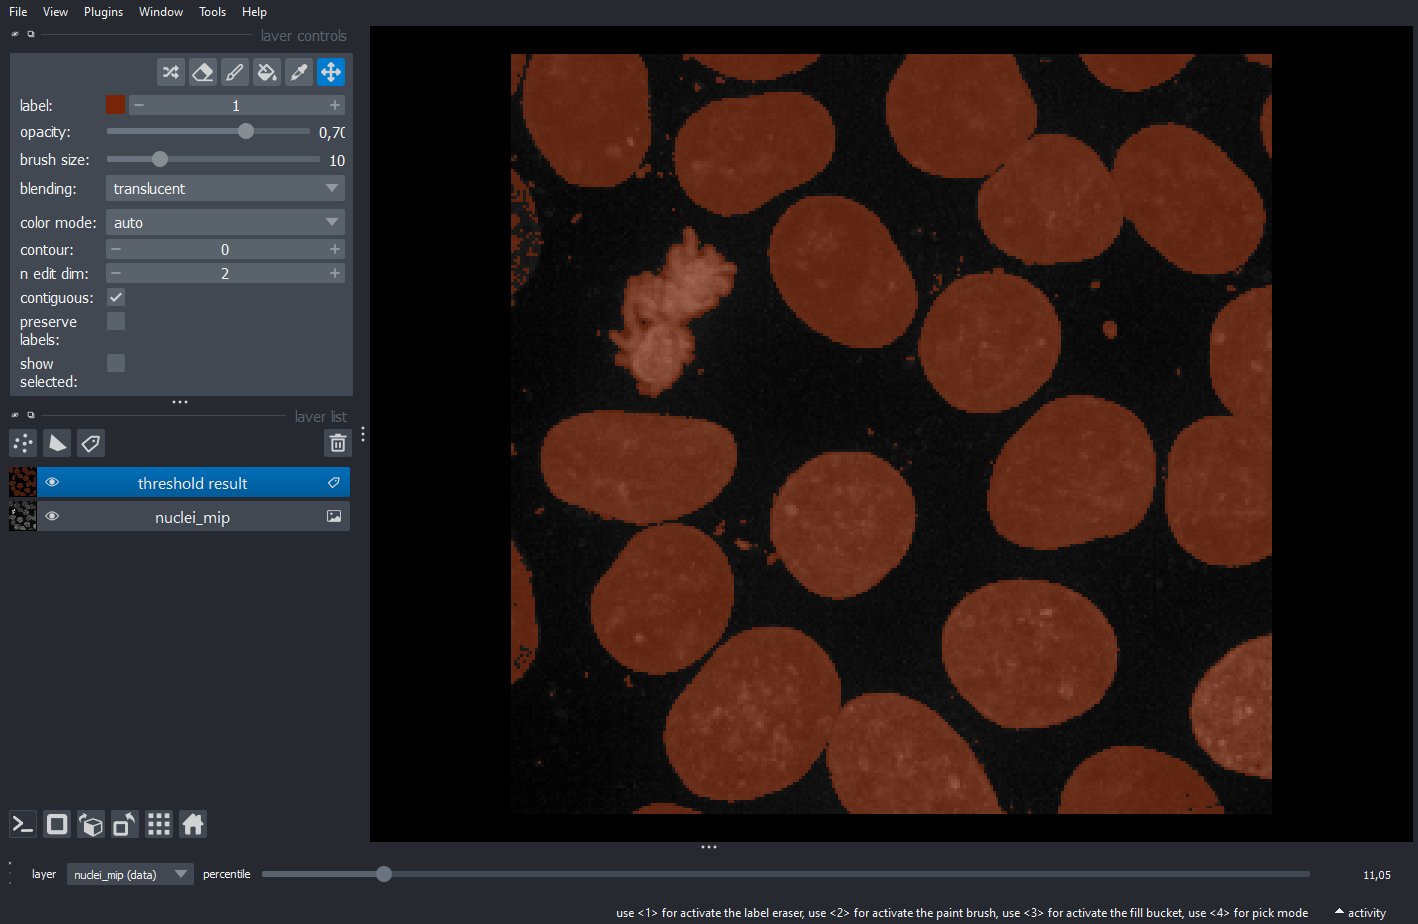

In [28]:
nbscreenshot(viewer)

In [29]:
from skimage import morphology

# Adding a custom key binding to the viewer for processing foreground data
@viewer.bind_key('Shift-P', overwrite=True)
def process_foreground(viewer):
    data = viewer.layers['threshold result'].data
    data_processed = morphology.remove_small_holes(data.astype(bool), 60)
    data_processed = morphology.remove_small_objects(data_processed, min_size=50)
    viewer.layers['threshold result'].data = data_processed

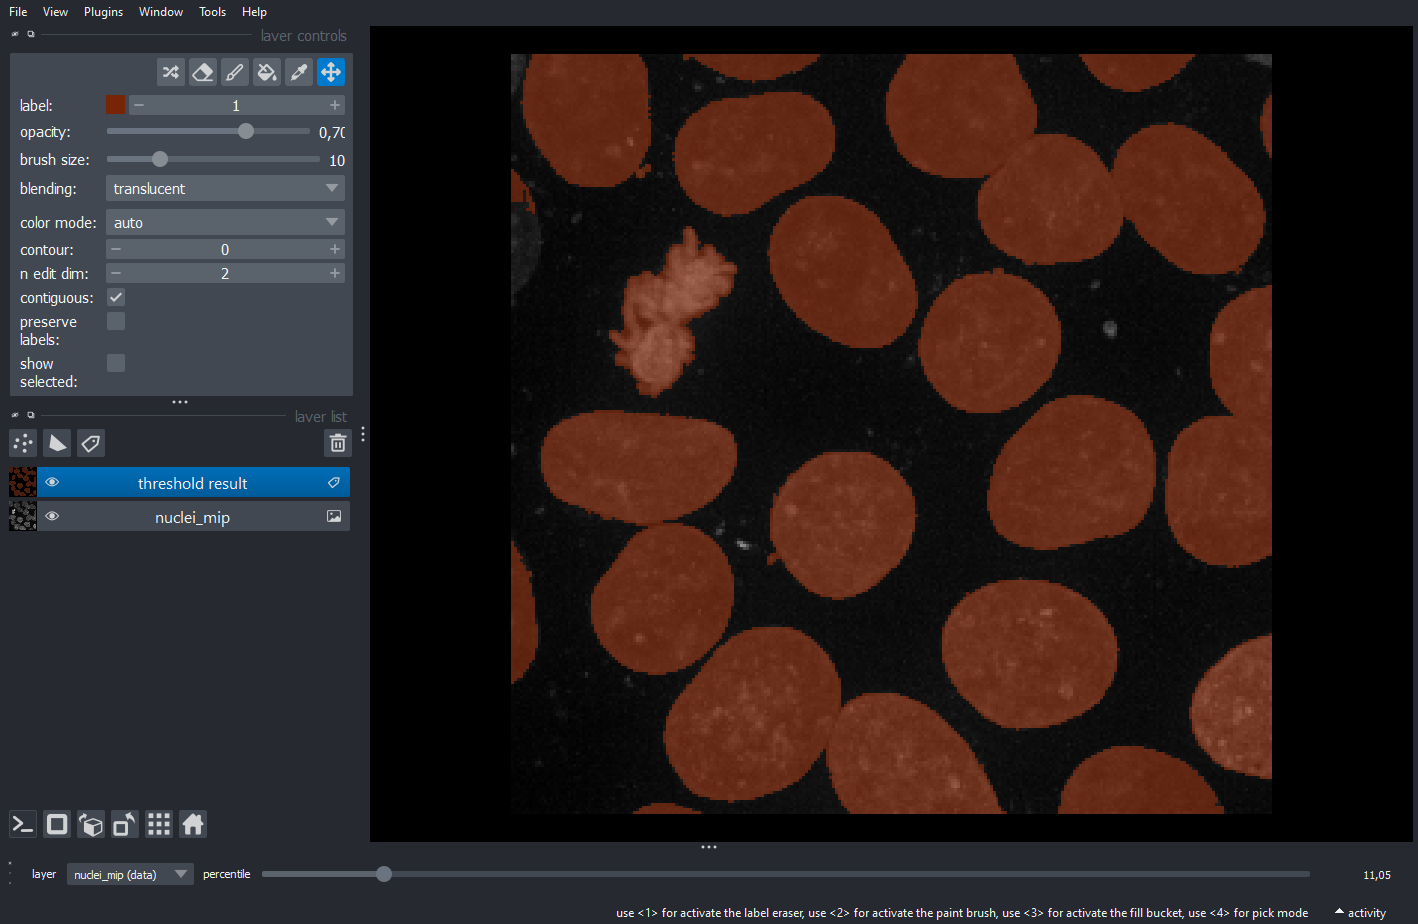

In [30]:
nbscreenshot(viewer)

In [35]:
# Add an empty labels layer
viewer.add_labels(np.zeros(nuclei_mip.shape, dtype=int), name='nuclei segmentation');

In [36]:
# Bind another keybinding to complete segmentation
@viewer.bind_key('Shift-S', overwrite=True)
def complete_segmentation(viewer):
    foreground = viewer.layers['threshold result'].data
    distance = ndimage.distance_transform_edt(foreground)
    smoothed_distance = filters.gaussian(distance, 10)
    peaks = feature.peak_local_max(
        smoothed_distance,
        footprint=np.ones((7, 7), dtype=bool),
        labels=measure.label(foreground).astype(np.int32)  # Convert labels to int32 explicitly
    )
    seeds = np.zeros(smoothed_distance.shape, dtype=bool)
    seeds[(peaks[:,0], peaks[:,1])] = 1

    markers = measure.label(seeds)
    nuclei_segmentation = segmentation.watershed(
        -smoothed_distance, 
        markers, 
        mask=foreground
    )
    viewer.layers['nuclei segmentation'].data = nuclei_segmentation

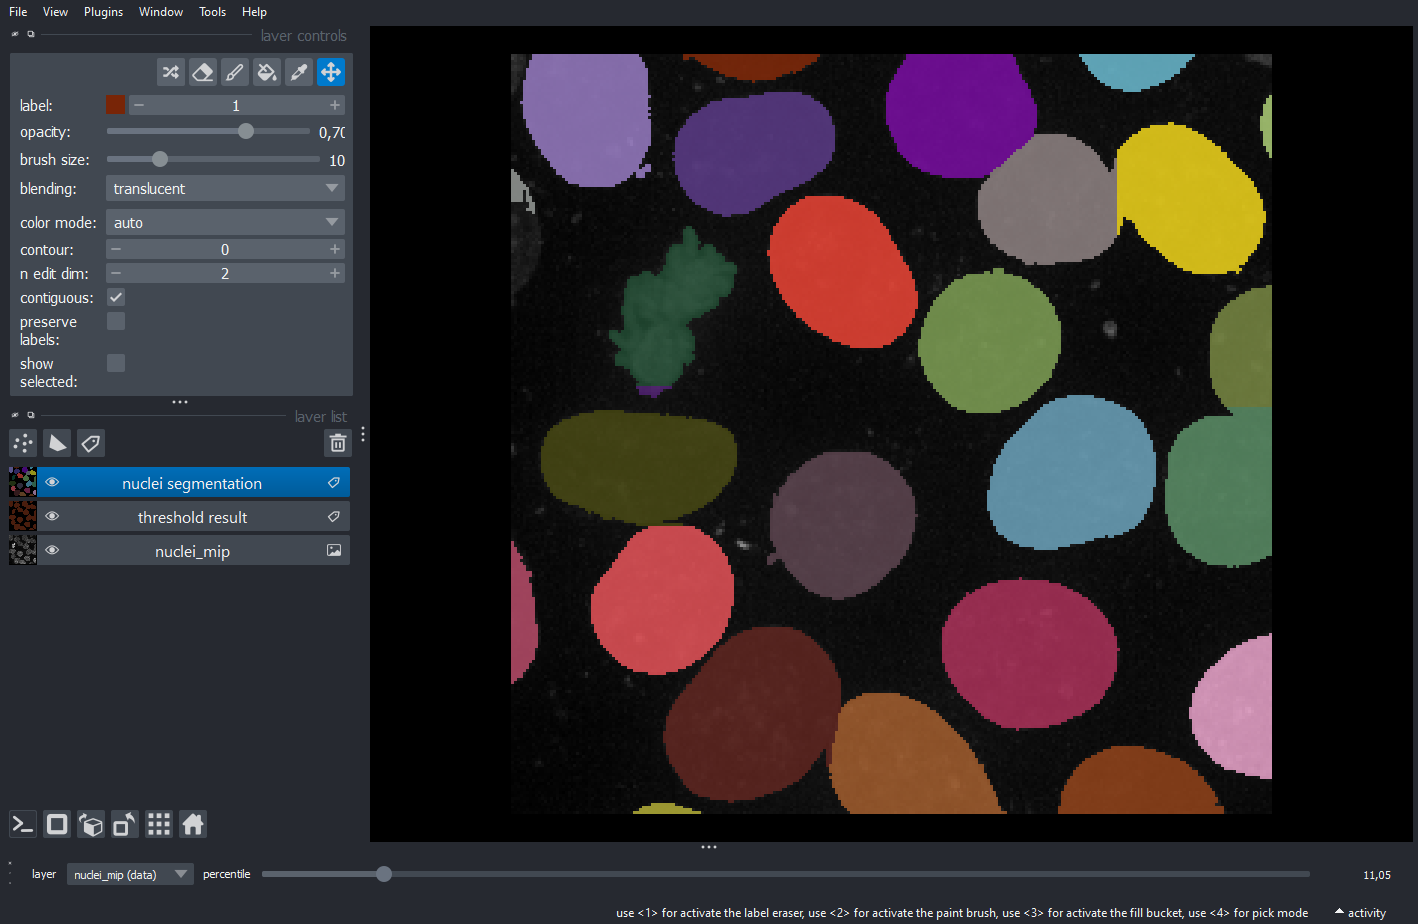

In [37]:
nbscreenshot(viewer)

## Conclusions

We've now seen how to interactively perform analyses by adding data to the napari viewer, and editing it as we moved through an analysis workflow. We've also seen how to extend the viewer with custom GUI functionality and keybindings, making analyses even more interactive!